In [71]:
"""
Task 1: Preparing the data in the requested format(tf.data.TFRecordDataset)
Author: Harish Somaghatta
Description: Data Preparation in TFRecord Format

"""

'\nTask 1: Preparing the data in the requested format(tf.data.TFRecordDataset)\nAuthor: Harish Somaghatta\nDescription: Data Preparation in TFRecord Format\n\n'

In [72]:
# Import the necessary libraries

import tensorflow as tf
import PIL
import numpy as np
import xml.etree.ElementTree as ET
import io
import os
import sklearn
from sklearn.preprocessing import LabelEncoder
from natsort import natsorted
import matplotlib.pyplot as plt


In [73]:
# Get the labels information

def get_labels_from_folders(image_folder):
    """
    Get folder names from the specified directory and can be used as labels for classification task.

    Parameters:
        image_folder (str): The path to the directory containing image folders.

    Returns:
        labels (list): A list of folder names found in the specified directory.
    """
    labels_list = []
    for folder_name in os.listdir(image_folder):
        folder_path = os.path.join(image_folder, folder_name)
        # Check if there is any folder after images folder
        if os.path.isdir(folder_path):
            # Append the folder names to the labels list
            labels_list.append(folder_name)
    return labels_list

In [74]:
# Make sure that you are in the correct path(Downloaded file path)
image_folder = r"archive\NEU-DET\train\images"
labels = get_labels_from_folders(image_folder)
print(labels)

['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']


In [75]:
# Label encoding
label_encoder = LabelEncoder()

# Encode the labels
encoded_labels = label_encoder.fit_transform(labels)
print("Categorical to numeric labels: ",encoded_labels)
encoded_labels = dict(zip(labels, encoded_labels))

# Print the encoded labels
print("Encoded labels: ", encoded_labels)

Categorical to numeric labels:  [0 1 2 3 4 5]
Encoded labels:  {'crazing': 0, 'inclusion': 1, 'patches': 2, 'pitted_surface': 3, 'rolled-in_scale': 4, 'scratches': 5}


In [76]:
def create_example(image_path, annotation_path):
    """
    Creates a TFRecord example from an image and its corresponding XML annotation.

    Parameters:
        image_path (str): Path to the image file.
        annotation_path (str): Path to the XML annotation file.

    Returns:
        tf.train.Example: TFRecord example containing image and annotation information.
    """
    # Get the XML file information
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    # Image information from annotation file
    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)
    filename = str(root.find('.//filename').text)
    source_id = str(root.find('.//source/database').text)
    image_np = np.array(PIL.Image.open(image_path)) # Convert jpg image file into ndarray type
    encodedrawdata = tf.io.encode_jpeg(image_np).numpy() # Encode the ndarray image
    image_format = filename.split('.')[-1]

    # Objects information from annotation file
    objects = root.findall('.//object') # Get multiple objects information
    xmin = [float(object_elem.find('bndbox/xmin').text) for object_elem in objects]
    xmax = [float(object_elem.find('bndbox/xmax').text) for object_elem in objects]
    ymin = [float(object_elem.find('bndbox/ymin').text) for object_elem in objects]
    ymax = [float(object_elem.find('bndbox/ymax').text) for object_elem in objects]
    text = [object_elem.find('name').text for object_elem in objects]
    text_label = [encoded_labels[label] for label in text]
    single = set(text_label).pop()
    difficult = [int(object_elem.find('difficult').text) for object_elem in objects]
    truncated = [int(object_elem.find('truncated').text) for object_elem in objects]
    view = [str(object_elem.find('pose').text) for object_elem in objects]
    
    # Create a TFRecord example
    example = tf.train.Example(features=tf.train.Features(feature={
        "image/width": tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        "image/height": tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename.encode('utf-8')])), # Encode the string
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[source_id.encode('utf-8')])),
        'image/encodedrawdata': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encodedrawdata])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_format.encode('utf-8')])),
        'image/object/class/single': tf.train.Feature(int64_list=tf.train.Int64List(value=[single])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=[t.encode('utf-8') for t in text])),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=text_label)),
        'image/object/difficult': tf.train.Feature(int64_list=tf.train.Int64List(value=difficult)),
        'image/object/truncated': tf.train.Feature(int64_list=tf.train.Int64List(value=truncated)),
        'image/object/view': tf.train.Feature(bytes_list=tf.train.BytesList(value=[v.encode('utf-8') for v in view])),
    }))
    
    # Return TFRecord example
    return example


In [77]:
def get_image_paths(image_folder):
    """
    Gets the paths of all JPEG images.

    Parameters:
        image_folder (str): Path to the image folder.

    Returns:
        image_paths: List of jpg images path.
    """
        
    image_paths = []

    for defect_folder in os.listdir(image_folder):
        defect_folder_path = os.path.join(image_folder, defect_folder)
        
        filenames = natsorted(os.listdir(defect_folder_path))

        for filename in filenames:
            if filename.lower().endswith('.jpg'):
                image_path = os.path.join(defect_folder_path, filename)
                image_paths.append(image_path)
    return image_paths
    

In [78]:
train_image_folder = r"archive\NEU-DET\train\images"
train_image_path = get_image_paths(train_image_folder)

test_image_folder = r"archive\NEU-DET\validation\images"
test_image_path = get_image_paths(test_image_folder)

num_train_files = len(train_image_path)
num_test_files = len(test_image_path)

print(f"Number of files in training path: {num_train_files}")
print(f"Number of files in testing path: {num_test_files}")


Number of files in training path: 1440
Number of files in testing path: 360


In [79]:
def create_tfrecords(image_folder, annotation_folder, output_folder, images_path):
    """
    Creates TFRecord files from images and respective annotations.

    Parameters:
        image_folder (str): Path to the images folder.
        annotation_folder (str): Path to the XML annotations folder.
        output_folder (str):TFRecord files saving path.
        images_path (list): Images path.

    Returns:
        None (Writes TFRecord examples of training and test to the file.)
    """
    # Create output folder if that is not available
    os.makedirs(output_folder, exist_ok=True)
    
    # Get the annotation files path
    annotations_path = [os.path.join(annotation_folder, filename) for filename in natsorted(os.listdir(annotation_folder))]
    print(f"Number of images: {len(images_path)}")
    print(f"Number of annotation files: {len(annotations_path)}")
    
    # Iterate over images and annotations 
    for i, (image_path, annotations_path) in enumerate(zip(images_path, annotations_path)):
        # Create path for the TFRecord file output
        output_path = os.path.join(output_folder, f"sample_{i+1}.tfrecord")
        # Create a TFRecord example 
        example = create_example(image_path, annotations_path)
        # Write the TFRecord example to the file
        with tf.io.TFRecordWriter(output_path) as writer:
            writer.write(example.SerializeToString())
    print(f"{i + 1} files written successfully.")

In [80]:
train_annotation_folder = r"archive\NEU-DET\train\annotations"
train_output_folder = "train_output.tfrecords"
create_tfrecords(train_image_folder, train_annotation_folder, train_output_folder, train_image_path)

test_annotation_folder = r"archive\NEU-DET\validation\annotations"
test_output_folder = "test_output.tfrecords"
create_tfrecords(test_image_folder, test_annotation_folder, test_output_folder, test_image_path)


Number of images: 1440
Number of annotation files: 1440
1440 files written successfully.
Number of images: 360
Number of annotation files: 360
360 files written successfully.


In [81]:
def map_fn(serialized_example):
    """
    Maps function for parsing a single TFRecord example.

    Parameters:
        serialized_example (tf.Tensor): Serialized TFRecord example.

    Returns:
        example and objects information
    """
    
    # Define the feature description dictionary
    feature_description = {
        "image/width": tf.io.FixedLenFeature([], tf.int64),
        "image/height": tf.io.FixedLenFeature([], tf.int64),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/source_id': tf.io.FixedLenFeature([], tf.string),
        'image/encodedrawdata': tf.io.FixedLenFeature([], tf.string),
        'image/format': tf.io.FixedLenFeature([], tf.string),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/text': tf.io.VarLenFeature(tf.string),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
        'image/object/class/single': tf.io.FixedLenFeature([], tf.int64),
        'image/object/difficult': tf.io.VarLenFeature(tf.int64),
        'image/object/truncated': tf.io.VarLenFeature(tf.int64),
        'image/object/view': tf.io.VarLenFeature(tf.string)
    }
    
    # Parse the single TFRecord example
    example = tf.io.parse_single_example(serialized_example, feature_description)
    

    # Extract the variable-length features (dense tensors from sparse tensors)
    width = example['image/width']
    height = example['image/height']
    # Converts byte string to numpy string 
    filename = tf.py_function(lambda x: x.numpy().decode('utf-8'), [example['image/filename']], tf.string)
    source_id = tf.py_function(lambda x: x.numpy().decode('utf-8'), [example['image/source_id']], tf.string)
    decode_image = tf.io.decode_jpeg(example['image/encodedrawdata'])
    img_format = tf.py_function(lambda x: x.numpy().decode('utf-8'), [example['image/format']], tf.string)
    xmin = tf.sparse.to_dense(example['image/object/bbox/xmin'])
    ymin = tf.sparse.to_dense(example['image/object/bbox/ymin'])
    xmax = tf.sparse.to_dense(example['image/object/bbox/xmax'])
    ymax = tf.sparse.to_dense(example['image/object/bbox/ymax'])
    text = tf.sparse.to_dense(example['image/object/class/text'], default_value='')
    label = tf.sparse.to_dense(example['image/object/class/label'])
    difficult = tf.sparse.to_dense(example['image/object/difficult'])
    single = example['image/object/class/single']
    truncated = tf.sparse.to_dense(example['image/object/truncated'])
    view = tf.sparse.to_dense(example['image/object/view'],  default_value='')
    
    # Return the parsed example and objects details
    return width, height, filename, source_id, decode_image, img_format, xmin, ymin, xmax, ymax, text, label, difficult, single, truncated, view

In [82]:
def print_dataset_details(dataset, dataset_type):
    """
    Print details of the given dataset.
    
    Parameters:
        dataset (tf.data.Dataset): Parsed dataset.
        dataset_type (str): Type of the dataset (e.g., "Train" or "Test").
        num_samples (int): Number of samples to print. Default is 2.

    Returns:
        None
    """
    for i, (width, height, filename, source_id, decode_image, img_format, xmin, ymin, xmax, ymax, text, label, difficult, single, truncated, view) in enumerate(dataset.take(1)):
        print(f"filename: {filename}, Width: {width}, Height: {height}, source_id = {source_id}")
        # print(f"Image: \n{decode_image}")
        # Convert the Numpy array to Image
        image = PIL.Image.fromarray(decode_image.numpy())
        plt.imshow(image)
        plt.show()
        
        print(f"xmin: {xmin.numpy()}, ymin: {ymin.numpy()}, xmax: {xmax.numpy()}, ymax: {ymax.numpy()}")
               
        decoded_texts = [element.decode('utf-8') for element in text.numpy() if element is not None]        
        print(f"Text: {decoded_texts}")

        print(f"Label: {label.numpy()}")
        print(f"Single: {single}")
        print(f"Difficult: {difficult.numpy()}")
        print(f"Truncated: {truncated.numpy()}")
        decoded_view = [element.decode('utf-8') for element in view.numpy() if element is not None]
        print(f"View: {decoded_view}")
    print("\n")
    

Training dataset sample: 

filename: b'crazing_6.jpg', Width: 200, Height: 200, source_id = b'NEU-DET'


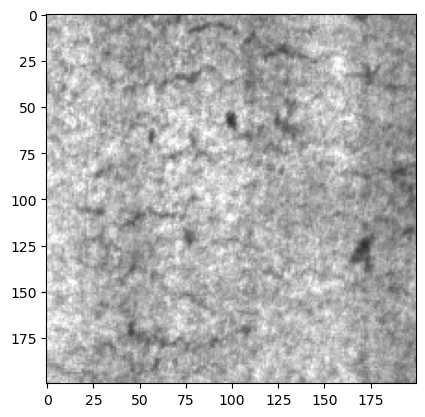

xmin: [27. 11.], ymin: [ 3. 89.], xmax: [196. 119.], ymax: [ 45. 199.]
Text: ['crazing', 'crazing']
Label: [0 0]
Single: 0
Difficult: [0 0]
Truncated: [0 0]
View: ['Unspecified', 'Unspecified']


Test dataset sample: 

filename: b'crazing_246.jpg', Width: 200, Height: 200, source_id = b'NEU-DET'


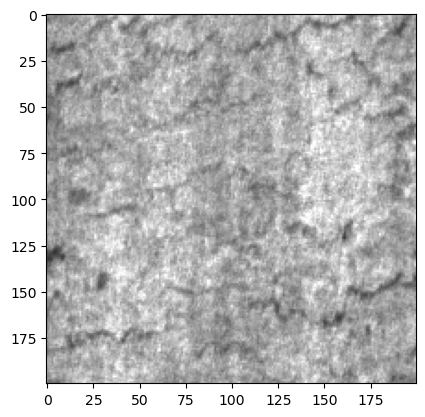

xmin: [ 4. 41.  1. 23.], ymin: [  1. 109.  73.  19.], xmax: [200. 199. 169. 179.], ymax: [ 60. 173. 124.  90.]
Text: ['crazing', 'crazing', 'crazing', 'crazing']
Label: [0 0 0 0]
Single: 0
Difficult: [0 0 0 0]
Truncated: [1 0 1 0]
View: ['Unspecified', 'Unspecified', 'Unspecified', 'Unspecified']




In [83]:

# Replace with the desired file number to visualize a specific sample
file_number = 6  

# Construct the filename using string formatting
train_filename = f"train_output.tfrecords/sample_{file_number}.tfrecord"
test_filename = f"test_output.tfrecords/sample_{file_number}.tfrecord"

raw_train_dataset = tf.data.TFRecordDataset(train_filename)
parsed_train_dataset = raw_train_dataset.map(map_fn)

raw_test_dataset = tf.data.TFRecordDataset(test_filename)
parsed_test_dataset = raw_test_dataset.map(map_fn)

# Print details for the specific sample
print("Training dataset sample: \n")
print_dataset_details(parsed_train_dataset, "Train")
print("Test dataset sample: \n")
print_dataset_details(parsed_test_dataset, "Test")